<a href="https://colab.research.google.com/github/ahmedmedrah/first_gop_debate_twitter_sentiment_analysis/blob/master/first_gop_debate_twitter_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
%matplotlib inline

In [2]:
df = pd.read_csv('/content/Sentiment.csv')
df.head()

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,name,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,1,No candidate mentioned,1.0,yes,1.0,Neutral,0.6578,None of the above,1.0000,NaN,I_Am_Kenzi,NaN,5,NaN,NaN,RT @NancyLeeGrahn: How did everyone feel about...,NaN,2015-08-07 09:54:46 -0700,629697200650592256,NaN,Quito
1,2,Scott Walker,1.0,yes,1.0,Positive,0.6333,None of the above,1.0000,NaN,PeacefulQuest,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,2015-08-07 09:54:46 -0700,629697199560069120,NaN,NaN
2,3,No candidate mentioned,1.0,yes,1.0,Neutral,0.6629,None of the above,0.6629,NaN,PussssyCroook,NaN,27,NaN,NaN,RT @TJMShow: No mention of Tamir Rice and the ...,NaN,2015-08-07 09:54:46 -0700,629697199312482304,NaN,NaN
3,4,No candidate mentioned,1.0,yes,1.0,Positive,1.0000,None of the above,0.7039,NaN,MattFromTexas31,NaN,138,NaN,NaN,RT @RobGeorge: That Carly Fiorina is trending ...,NaN,2015-08-07 09:54:45 -0700,629697197118861312,Texas,Central Time (US & Canada)
4,5,Donald Trump,1.0,yes,1.0,Positive,0.7045,None of the above,1.0000,NaN,sharonDay5,NaN,156,NaN,NaN,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,NaN,2015-08-07 09:54:45 -0700,629697196967903232,NaN,Arizona


# Preprocessing the data

Only keeping 'text', 'sentiment' coulmns and we only classifying Positive or Negative sentiments

In [3]:
data = df[['text','sentiment']]
data = data[data.sentiment != 'Neutral']
data.head()

,text,sentiment
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive
3,RT @RobGeorge: That Carly Fiorina is trending ...,Positive
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive
5,"RT @GregAbbott_TX: @TedCruz: ""On my first day ...",Positive
6,RT @warriorwoman91: I liked her and was happy ...,Negative


make the text only lower case & remove the special characters

In [4]:
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-z0-9\s]','',x)))
data.head()

,text,sentiment
1,rt scottwalker didnt catch the full gopdebate ...,Positive
3,rt robgeorge that carly fiorina is trending h...,Positive
4,rt danscavino gopdebate w realdonaldtrump deli...,Positive
5,rt gregabbotttx tedcruz on my first day i will...,Positive
6,rt warriorwoman91 i liked her and was happy wh...,Negative


removing "rt" notation which means retweeted ,
but it doesn't give any information to the data 

In [5]:
for idx,row in tqdm(data.iterrows()):
    row[0] = row[0].replace('rt ',' ')

data.head()    

10729it [00:01, 8662.57it/s]


,text,sentiment
1,scottwalker didnt catch the full gopdebate la...,Positive
3,robgeorge that carly fiorina is trending hou...,Positive
4,danscavino gopdebate w realdonaldtrump delive...,Positive
5,gregabbotttx tedcruz on my first day i will r...,Positive
6,warriorwoman91 i liked her and was happy when...,Negative


Our data distribution has a huge class imbalance 

Positive:  4472
Negative:  16986


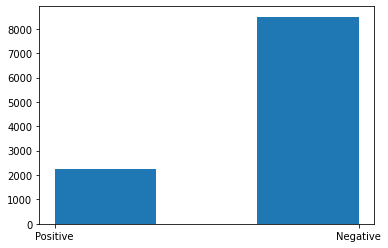

In [6]:
print('Positive: ',data[ data['sentiment'] == 'Positive'].size)
print('Negative: ',data[ data['sentiment'] == 'Negative'].size)
x = data['text']
y = data['sentiment']
plt.hist(y,bins=3)
plt.show()

# Lets try Machine Learning first
##### We are going to use TfidfVectorizer as a preprocessing step

What is a TfidfVectorizer?
TF (Term Frequency): The number of times a word appears in a document. A higher value means a term appears more often than others.

IDF (Inverse Document Frequency): Words that occur many times a document, but also occur many times in many others, may be irrelevant. IDF is a measure of how significant a term is in the entire corpus.

The TfidfVectorizer converts a collection of raw documents into a matrix of TF-IDF features.

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score


y = LabelEncoder().fit_transform(y)
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state = 42)

In [0]:
vectorizer = TfidfVectorizer(stop_words='english',max_df=0.8)
v_train=vectorizer.fit_transform(x_train) 
v_test=vectorizer.transform(x_test)

##### Using PassiveAggresiveClassifier as our model

What is a PassiveAggressiveClassifier?
Passive Aggressive algorithms are online learning algorithms. Such an algorithm remains passive for a correct classification outcome, and turns aggressive in the event of a miscalculation, updating and adjusting. Unlike most other algorithms, it does not converge. Its purpose is to make updates that correct the loss, causing very little change in the norm of the weight vector.

In [9]:
pac=PassiveAggressiveClassifier(C=0.01,random_state=42)
pac.fit(v_train,y_train)

y_pred=pac.predict(v_test)
score=accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 86.58%


Turns out that PassiveAggressiveClassifier deals well with our class imbalance dataset

In [10]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for i in tqdm(range(len(x_test))):
   
    if y_pred[i] == y_test[i]:
        if y_test[i] == 1:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if y_pred[i] == 1:
        neg_cnt += 1
    else:
        pos_cnt += 1



print(f"\nPositive Accuracy {round(pos_correct/pos_cnt*100,2)} %")
print(f"Negative Accuracy {round(neg_correct/neg_cnt*100,2)} %")

100%|██████████| 2683/2683 [00:00<00:00, 380964.75it/s]


Positive Accuracy 88.88 %
Negative Accuracy 73.43 %


In [11]:
cmnt = ["I hate summer because it is so sweaty",
        "I love walking in the park at sunset"]
cmnt = vectorizer.transform(cmnt)
pred = pac.predict(cmnt)
for p in pred:
    if p == 0:
        print('Negative')
    else:
        print('Positive')

Negative
Positive


# Now lets try DeepLearning

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


We are using Tokenizer with top 3000 words in our dataset then padding our text with zeros to data have the same length

In [0]:
max_fatures = 3000
tokenizer = Tokenizer(num_words=max_fatures)
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X,y, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(8046, 29) (8046,)
(2683, 29) (2683,)


#### Using Embedding layer to extract some meanings of our data > LSTM layer as our model > Desne Layer as a classifying unit

In [15]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(LSTM(lstm_out))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 29, 128)           384000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 197       
Total params: 638,997
Trainable params: 638,997
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
batch_size = 64
epochs = 10
model.fit(X_train, Y_train, epochs = epochs, batch_size=batch_size)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
8046/8046 [==============================] - 8s 940us/step - loss: 0.4337 - accuracy: 0.8164
Epoch 2/10
8046/8046 [==============================] - 7s 887us/step - loss: 0.2977 - accuracy: 0.8756
Epoch 3/10
8046/8046 [==============================] - 7s 881us/step - loss: 0.2414 - accuracy: 0.9027
Epoch 4/10
8046/8046 [==============================] - 7s 880us/step - loss: 0.2047 - accuracy: 0.9149
Epoch 5/10
8046/8046 [==============================] - 7s 871us/step - loss: 0.1735 - accuracy: 0.9314
Epoch 6/10
8046/8046 [==============================] - 7s 879us/step - loss: 0.1448 - accuracy: 0.9426
Epoch 7/10
8046/8046 [==============================] - 7s 882us/step - loss: 0.1249 - accuracy: 0.9490
Epoch 8/10
8046/8046 [==============================] - 7s 894us/step - loss: 0.1114 - accuracy: 0.9559
Epoch 9/10
8046/8046 [==============================] - 7s 875us/step - loss: 0.0977 - accuracy: 0.9621
Epoch 10/10
8046/8046 [==============================] - 7s 883u

In [17]:
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc),"%")

score: 0.69
acc: 0.83 %


#### It doesn't work well with our class imbalance

In [18]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for i in tqdm(range(len(X_test))):
    
    result = model.predict(X_test[i].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if round(result[0]) == Y_test[i]:
        if Y_test[i] == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if Y_test[i] == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1



print(f"\nPositive Accuracy {round(pos_correct/pos_cnt*100,2)} %")
print(f"Negative Accuracy {round(neg_correct/neg_cnt*100,2)} %")

100%|██████████| 2683/2683 [00:13<00:00, 205.40it/s]


Positive Accuracy 57.95 %
Negative Accuracy 89.23 %


In [20]:
cmnt = ["I hate summer because it is so sweaty",
        "I love walking in the park at sunset"]

cmnt = tokenizer.texts_to_sequences(cmnt)
cmnt = pad_sequences(cmnt, maxlen=29, dtype='int32', value=0)

for p in cmnt:
    sentiment = model.predict(np.expand_dims(p,axis=0),batch_size=1,verbose = 2)[0]
    if(np.round(sentiment[0]) == 0):
        print("negative")
    else:
        print("positive")

negative
positive
